In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import pickle

In [2]:

def class_balance(titanic_df):
  survived = titanic_df[titanic_df['survived'] == 0].head(len(titanic_df[titanic_df['survived'] == 1]))
  not_survived = titanic_df[titanic_df['survived'] == 1]
  titanic_df = pd.concat([not_survived, survived])
  return titanic_df

In [3]:
def survived_plot(titanic_df, title):
  sns.countplot(data=titanic_df, x='survived', hue='survived')
  plt.title(title)
  plt.show()

In [4]:
def roc_plot(y_test, y_pred_probs, classifier):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC Curve'.format(classifier))
    plt.show()
    print(roc_auc_score(y_test, y_pred_probs))

         survived         age  n_siblings_spouses       parch        fare
count  891.000000  891.000000          891.000000  891.000000  891.000000
mean     0.383838   29.361582            0.523008    0.381594   32.204208
std      0.486592   13.019697            1.102743    0.806057   49.693429
min      0.000000    0.420000            0.000000    0.000000    0.000000
25%      0.000000   22.000000            0.000000    0.000000    7.910400
50%      0.000000   28.000000            0.000000    0.000000   14.454200
75%      1.000000   35.000000            1.000000    0.000000   31.000000
max      1.000000   80.000000            8.000000    6.000000  512.329200


C:\Users\Gombar.Egon\AppData\Local\Temp\ipykernel_17324\3426459756.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_df.corr(), annot=True)


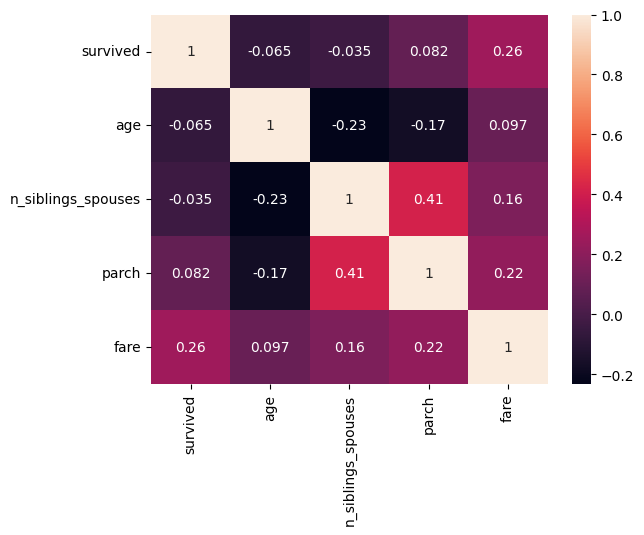

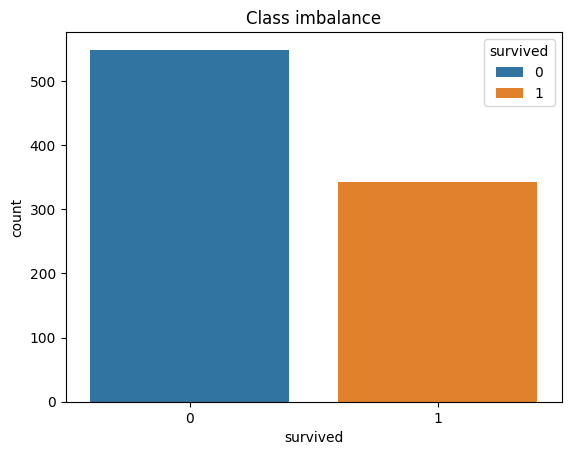

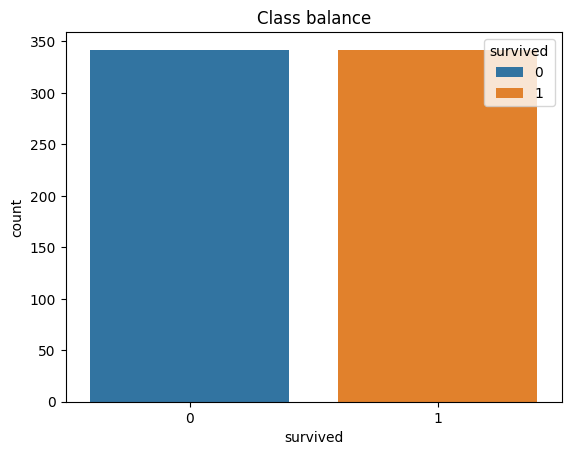

In [5]:
titanic_df = pd.read_csv('Datasets/titanic.csv')
print(titanic_df.describe())
sns.heatmap(titanic_df.corr(), annot=True)
plt.show()

titanic_df = titanic_df.drop("embark_town", axis=1)
survived_plot(titanic_df, "Class imbalance")
titanic_df = class_balance(titanic_df)
survived_plot(titanic_df, "Class balance")

In [11]:
titanic_dummies = pd.get_dummies(titanic_df).astype('float32')

X = titanic_dummies.drop("survived", axis=1).values

y = titanic_dummies["survived"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [12]:
logreg_steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

knn_steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]

tree_steps = [('scaler', StandardScaler()),
         ('tree', DecisionTreeClassifier())]

perc_steps = [('scaler', StandardScaler()),
         ('perc', Perceptron())]

gaus_steps = [('scaler', StandardScaler()),
         ('gaus', GaussianNB())]

In [13]:
logreg_pipeline = Pipeline(logreg_steps)
knn_pipeline = Pipeline(knn_steps)
tree_pipeline = Pipeline(tree_steps)
perc_pipeline = Pipeline(perc_steps)
gaus_pipeline = Pipeline(gaus_steps)

In [14]:
logreg_params = {"logreg__penalty": ["l1", "l2"],
         "logreg__tol": np.linspace(0.0001, 1.0, 50),
         "logreg__C": np.linspace(0.1, 1.0, 50),
         "logreg__class_weight": ["balanced", {0:0.8, 1:0.2}],
         "logreg__solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
         "logreg__multi_class": ['auto', 'ovr', 'multinomial']}

knn_params = {"knn__n_neighbors": np.arange(1, 20),
              "knn__weights": ['uniform', 'distance'],
              "knn__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "knn__leaf_size": np.arange(10, 100)}

tree_params = {"tree__criterion": ['gini', 'entropy', 'log_loss'],
               "tree__splitter": ['best', 'random'],
               "tree__max_features": ['auto', 'sqrt', 'log2'],
               "tree__ccp_alpha": np.linspace(0.0001, 1.0, 50)}

perc_params = {"perc__penalty": ['l2', 'l1', 'elasticnet'],
         "perc__tol": np.linspace(0.0001, 1.0, 50),
         "perc__alpha": np.linspace(0.0001, 1.0, 50),
         "perc__class_weight": ["balanced", {0:0.8, 1:0.2}],}

gaus_params = {"gaus__var_smoothing": np.linspace(0.0001, 1.0, 50)}

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

logreg_cv = RandomizedSearchCV(logreg_pipeline, param_distributions=logreg_params, cv=kf, n_iter=20)
knn_cv = RandomizedSearchCV(knn_pipeline, param_distributions=knn_params, cv=kf, n_iter=20)
tree_cv = RandomizedSearchCV(tree_pipeline, param_distributions=tree_params, cv=kf, n_iter=20)
perc_cv = RandomizedSearchCV(perc_pipeline, param_distributions=perc_params, cv=kf, n_iter=20)
gaus_cv = RandomizedSearchCV(gaus_pipeline, param_distributions=gaus_params, cv=kf, n_iter=20) 

In [25]:
logreg_cv.fit(X_train, y_train)
knn_cv.fit(X_train, y_train)
tree_cv.fit(X_train, y_train)
perc_cv.fit(X_train, y_train)
gaus_cv.fit(X_train, y_train)

c:\Users\Gombar.Egon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gombar.Egon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gombar.Egon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Gombar.Egon\AppData\Local\Programs\Python\Py

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gaus', GaussianNB())]),
                   n_iter=20,
                   param_distributions={'gaus__var_smoothing': array([1.00000000e-04, 2.05061224e-02, 4.09122449e-02, 6.13183673e-02,
       8.17244898e-02, 1.02130612e-01, 1.22536735e-01, 1.42942857e-01,
       1.63348980e-01, 1.837551...
       4.89846939e-01, 5.10253061e-01, 5.30659184e-01, 5.51065306e-01,
       5.71471429e-01, 5.91877551e-01, 6.12283673e-01, 6.32689796e-01,
       6.53095918e-01, 6.73502041e-01, 6.93908163e-01, 7.14314286e-01,
       7.34720408e-01, 7.55126531e-01, 7.75532653e-01, 7.95938776e-01,
       8.16344898e-01, 8.36751020e-01, 8.57157143e-01, 8.77563265e-01,
       8.97969388e-01, 9.18375510e-01, 9.38781633e-01, 9.59187755e-01,
       9.79593878e-01, 1.00000000e+00])})

In [17]:
def save_model(model, filename):
    # save model
    pickle.dump(model, open("Models/" + filename, "wb"))
    
def load_model(filename):
    # load model
    loaded_model = pickle.load(open("Models/" + filename, "rb"))

In [18]:
save_model(knn_cv, "titanic_knn.pickle")
save_model(logreg_cv, "titanic_logreg.pickle")
save_model(tree_cv, "titanic_tree.pickle")
save_model(perc_cv, "titanic_prec.pickle")
save_model(gaus_cv, "titanic_gaus.pickle")

In [29]:
logreg_y_pred = logreg_cv.predict(X_test)
logreg_y_pred_probs = logreg_cv.predict_proba(X_test)[:, 1]

knn_y_pred = knn_cv.predict(X_test)
knn_y_pred_probs = knn_cv.predict_proba(X_test)[:, 1]

tree_y_pred = tree_cv.predict(X_test)
tree_y_pred_probs = tree_cv.predict_proba(X_test)[:, 1]

perc_y_pred = perc_cv.predict(X_test)
#perc_y_pred_probs = perc_cv.predict_proba(X_test)[:, 1]

gaus_y_pred = gaus_cv.predict(X_test)
gaus_y_pred_probs = gaus_cv.predict_proba(X_test)[:, 1]

[[86 17]
 [27 76]]
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.80       103
         1.0       0.82      0.74      0.78       103

    accuracy                           0.79       206
   macro avg       0.79      0.79      0.79       206
weighted avg       0.79      0.79      0.79       206



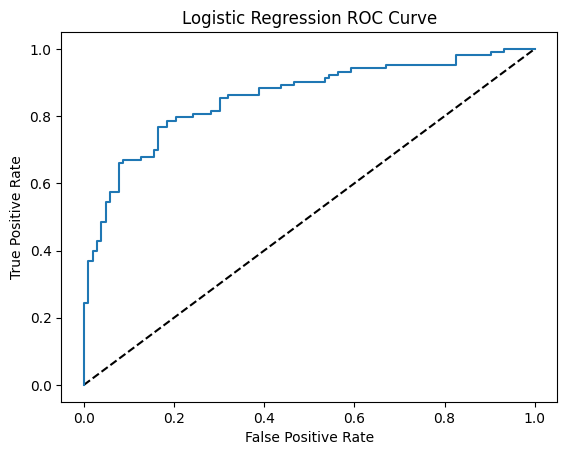

0.8556885663116223
[[82 21]
 [19 84]]
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       103
         1.0       0.80      0.82      0.81       103

    accuracy                           0.81       206
   macro avg       0.81      0.81      0.81       206
weighted avg       0.81      0.81      0.81       206



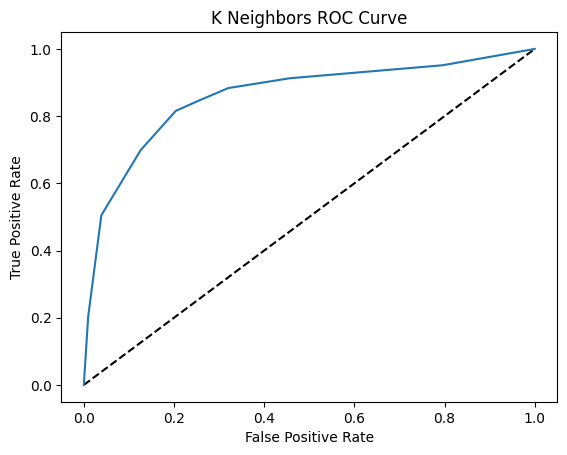

0.8594589499481573
[[88 15]
 [34 69]]
              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       103
         1.0       0.82      0.67      0.74       103

    accuracy                           0.76       206
   macro avg       0.77      0.76      0.76       206
weighted avg       0.77      0.76      0.76       206



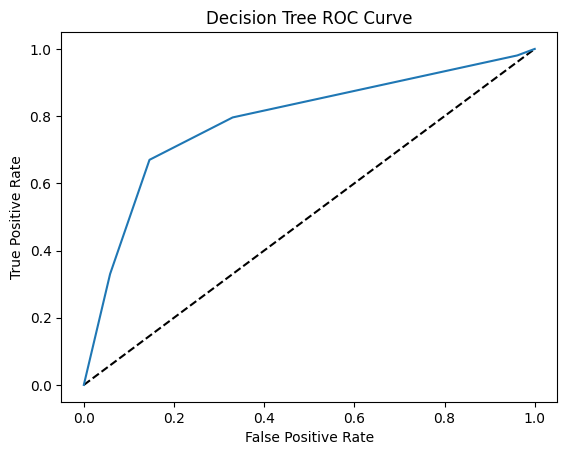

0.7875860118767084
[[63 40]
 [26 77]]
              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66       103
         1.0       0.66      0.75      0.70       103

    accuracy                           0.68       206
   macro avg       0.68      0.68      0.68       206
weighted avg       0.68      0.68      0.68       206

[[85 18]
 [37 66]]
              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       103
         1.0       0.79      0.64      0.71       103

    accuracy                           0.73       206
   macro avg       0.74      0.73      0.73       206
weighted avg       0.74      0.73      0.73       206



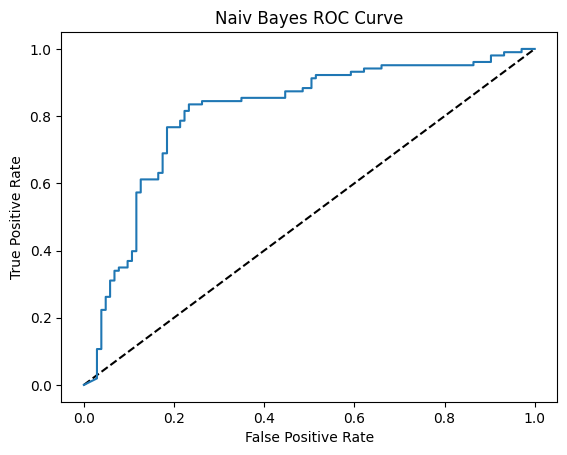

0.810443962673202


In [27]:
print(confusion_matrix(y_test, logreg_y_pred))
print(classification_report(y_test, logreg_y_pred))
roc_plot(y_test, logreg_y_pred_probs, "Logistic Regression")

print(confusion_matrix(y_test, knn_y_pred))
print(classification_report(y_test, knn_y_pred))
roc_plot(y_test, knn_y_pred_probs, "K Neighbors")

print(confusion_matrix(y_test, tree_y_pred))
print(classification_report(y_test, tree_y_pred))
roc_plot(y_test, tree_y_pred_probs, "Decision Tree")

print(confusion_matrix(y_test, perc_y_pred))
print(classification_report(y_test, perc_y_pred))
#roc_plot(y_test, perc_y_pred_probs, "Perception")

print(confusion_matrix(y_test, gaus_y_pred))
print(classification_report(y_test, gaus_y_pred))
roc_plot(y_test, gaus_y_pred_probs, "Naiv Bayes")